In [36]:
import torch, pickle
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
inp1,inp2,outp=np.load('all_file_nef.pkl', allow_pickle=True)

In [37]:
from torch.utils.data import DataLoader, TensorDataset

In [38]:
X = np.vstack([outp, inp2]).T
y = inp1.reshape(-1, 1)  # Ensure y is a column vector

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())

Using device: cuda
True


In [40]:
class ANN(nn.Module):
    def __init__(self, input_size=2, hidden_size=40, output_size=1, num_hidden=8):
        super(ANN, self).__init__()
        layers = [input_size] + [hidden_size] * num_hidden + [output_size]
        modules = []
        for i in range(num_hidden):
            modules.append(nn.Linear(layers[i], layers[i + 1]))
            modules.append(nn.ReLU())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Linear output layer
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        return self.net(x)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize Input & Output
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [42]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

In [43]:
batch_size = int(1024/2)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [44]:
model = ANN().to(device)

# Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [45]:
model.load_state_dict(torch.load("model_weights_inv.pth"))
model.eval()  # Set to evaluation mode

ANN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): ReLU()
    (8): Linear(in_features=40, out_features=40, bias=True)
    (9): ReLU()
    (10): Linear(in_features=40, out_features=40, bias=True)
    (11): ReLU()
    (12): Linear(in_features=40, out_features=40, bias=True)
    (13): ReLU()
    (14): Linear(in_features=40, out_features=40, bias=True)
    (15): ReLU()
    (16): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [10]:
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_loss:.6f}")

Epoch 1/20, Train Loss: 0.027337, Val Loss: 0.000052
Epoch 2/20, Train Loss: 0.000094, Val Loss: 0.000034
Epoch 3/20, Train Loss: 0.000085, Val Loss: 0.000039
Epoch 4/20, Train Loss: 0.000069, Val Loss: 0.000018
Epoch 5/20, Train Loss: 0.000064, Val Loss: 0.000112
Epoch 6/20, Train Loss: 0.000013, Val Loss: 0.000012
Epoch 7/20, Train Loss: 0.000021, Val Loss: 0.000022
Epoch 8/20, Train Loss: 0.000020, Val Loss: 0.000007
Epoch 9/20, Train Loss: 0.000019, Val Loss: 0.000058
Epoch 10/20, Train Loss: 0.000018, Val Loss: 0.000007
Epoch 11/20, Train Loss: 0.000006, Val Loss: 0.000006
Epoch 12/20, Train Loss: 0.000008, Val Loss: 0.000007
Epoch 13/20, Train Loss: 0.000008, Val Loss: 0.000008
Epoch 14/20, Train Loss: 0.000008, Val Loss: 0.000005
Epoch 15/20, Train Loss: 0.000007, Val Loss: 0.000006
Epoch 16/20, Train Loss: 0.000004, Val Loss: 0.000004
Epoch 17/20, Train Loss: 0.000005, Val Loss: 0.000005
Epoch 18/20, Train Loss: 0.000004, Val Loss: 0.000004
Epoch 19/20, Train Loss: 0.000004, Va

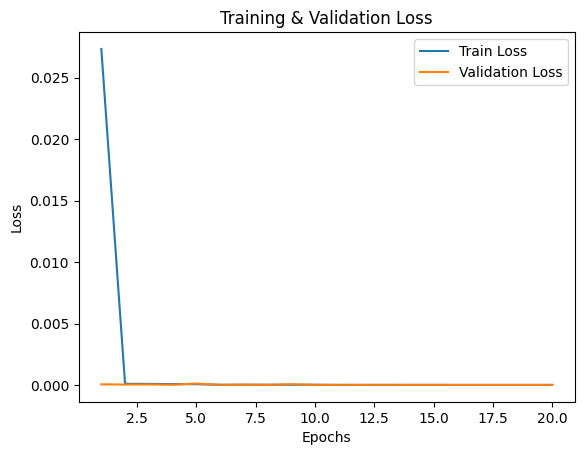

In [13]:
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
#plt.xlim(5,20)
plt.show()

In [46]:
def predict(new_inputs):
    """
    Predict outputs for new input data.

    Parameters:
    new_inputs (np.array): Array of shape (n_samples, 2) or (2,)

    Returns:
    np.array: Predicted outputs in original scale
    """
    model.eval()

    new_inputs = np.atleast_2d(new_inputs)  # Ensures shape (n_samples, 2)

    if new_inputs.shape[1] != 2:
        raise ValueError("Each input must have 2 features")

    inputs_scaled = scaler_X.transform(new_inputs)
    inputs_tensor = torch.tensor(inputs_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred_scaled = model(inputs_tensor)

    pred = scaler_y.inverse_transform(pred_scaled.cpu().numpy())
    return pred.flatten()  # Returns flat array of shape (n_samples,)

In [47]:
torch.tensor([-7.7,1.1])

tensor([-7.7000,  1.1000])

In [48]:
predict(torch.tensor([-7.78,1.1]))

array([-8.702637], dtype=float32)

In [41]:
# torch.save(model.state_dict(), 'model_weights_inv.pth')
# torch.save(model, 'model_inv.pth')

In [49]:
from eval_max import get_max
from constants import *
from numpy import sqrt
def x_to_b_3PN(M0,et,eta,n):
    x=(M0*tsun*n)**(2/3)
    ww=(sqrt(-1 + et**2)/x - (-6*et**2 - eta + 7*et**2*eta)/(6.*sqrt(-1 + et**2)) +
    (x*(738 - 792*et**2 + 1242*et**4 + 69*eta - 690*et**2*eta - 1539*et**4*eta + 17*eta**2 -
    58*et**2*eta**2 + 365*et**4*eta**2))/(72.*(-1 + et**2)**1.5) -
    (x**2*(-4974480 - 20729520*et**2 + 12383280*et**4 - 13320720*et**6 +
    13150620*eta + 47850156*et**2*eta + 3814020*et**4*eta + 18616500*et**6*eta -
    348705*pi**2*eta - 1046115*et**2*pi**2*eta - 5646060*eta**2 -
    1074780*et**2*eta**2 - 8566740*et**4*eta**2 - 10930500*et**6*eta**2 +
    14420*eta**3 + 165900*et**2*eta**3 + 1575420*et**4*eta**3 + 2387140*et**6*eta**3))/
    (181440.*(-1 + et**2)**2.5))
    return ww


def from_n0_to_f(n0, M0, e0):
    eta = 1 / 4

    x0 = (M0 * n0 * tsun) ** (2 / 3)
    b0 = x_to_b_3PN(M0, e0, eta, n0)

    return get_max(eta, b0, e0) / (M0 * tsun) / (2 * np.pi)
from_n0_to_f_vec = np.vectorize(from_n0_to_f)

In [50]:
narr=np.logspace(-10,-6.5,100)
earr=np.linspace(1.1,2,len(narr))

In [51]:
res=from_n0_to_f_vec(narr,1e9,earr)

In [52]:
np.log10(res)

array([-9.07803253, -9.09879312, -9.11501655, -9.12737521, -9.13640562,
       -9.142535  , -9.14611625, -9.14744273, -9.14675664, -9.14426465,
       -9.1401439 , -9.13454653, -9.12760332, -9.11942802, -9.11012421,
       -9.0997777 , -9.08846862, -9.07626753, -9.06323598, -9.04943043,
       -9.03490351, -9.01969914, -9.00386065, -8.98742505, -8.97042646,
       -8.95289875, -8.93486975, -8.91636623, -8.89741346, -8.87803343,
       -8.85824872, -8.83807783, -8.81753952, -8.79665054, -8.77542688,
       -8.75388305, -8.73203379, -8.70989186, -8.68746861, -8.66477615,
       -8.64182568, -8.61862651, -8.59518905, -8.57152155, -8.54763333,
       -8.52353194, -8.49922552, -8.47472103, -8.4500256 , -8.42514559,
       -8.40008755, -8.37485746, -8.3494609 , -8.32390307, -8.29818963,
       -8.27232529, -8.24631487, -8.22016304, -8.19387405, -8.16745198,
       -8.14090127, -8.1142254 , -8.08742844, -8.06051374, -8.03348497,
       -8.00634542, -7.97909833, -7.95174698, -7.92429438, -7.89

In [53]:
predict_vec = np.vectorize(lambda x, y: predict(np.array([x, y]))[0])

In [54]:
predictions = predict_vec(np.log10(res), earr)

In [55]:
predictions

array([-10.002723 ,  -9.964254 ,  -9.929837 ,  -9.897276 ,  -9.860989 ,
        -9.827473 ,  -9.79265  ,  -9.755541 ,  -9.715753 ,  -9.682007 ,
        -9.648222 ,  -9.612197 ,  -9.5746355,  -9.535688 ,  -9.503315 ,
        -9.47017  ,  -9.434756 ,  -9.400291 ,  -9.364986 ,  -9.328897 ,
        -9.292679 ,  -9.261681 ,  -9.229213 ,  -9.191625 ,  -9.152764 ,
        -9.113155 ,  -9.077204 ,  -9.044782 ,  -9.011833 ,  -8.978492 ,
        -8.943744 ,  -8.907503 ,  -8.871182 ,  -8.834191 ,  -8.798281 ,
        -8.763467 ,  -8.72848  ,  -8.692902 ,  -8.657196 ,  -8.623285 ,
        -8.589127 ,  -8.551666 ,  -8.51542  ,  -8.481183 ,  -8.4453745,
        -8.407672 ,  -8.371265 ,  -8.335956 ,  -8.30347  ,  -8.268853 ,
        -8.233921 ,  -8.198548 ,  -8.164568 ,  -8.129911 ,  -8.095842 ,
        -8.058712 ,  -8.022045 ,  -7.9837904,  -7.9477897,  -7.9132166,
        -7.8785043,  -7.84367  ,  -7.808717 ,  -7.77401  ,  -7.7378864,
        -7.7006116,  -7.6665454,  -7.632688 ,  -7.597466 ,  -7.5

In [29]:
np.log10(narr)

array([-10.        ,  -9.96464646,  -9.92929293,  -9.89393939,
        -9.85858586,  -9.82323232,  -9.78787879,  -9.75252525,
        -9.71717172,  -9.68181818,  -9.64646465,  -9.61111111,
        -9.57575758,  -9.54040404,  -9.50505051,  -9.46969697,
        -9.43434343,  -9.3989899 ,  -9.36363636,  -9.32828283,
        -9.29292929,  -9.25757576,  -9.22222222,  -9.18686869,
        -9.15151515,  -9.11616162,  -9.08080808,  -9.04545455,
        -9.01010101,  -8.97474747,  -8.93939394,  -8.9040404 ,
        -8.86868687,  -8.83333333,  -8.7979798 ,  -8.76262626,
        -8.72727273,  -8.69191919,  -8.65656566,  -8.62121212,
        -8.58585859,  -8.55050505,  -8.51515152,  -8.47979798,
        -8.44444444,  -8.40909091,  -8.37373737,  -8.33838384,
        -8.3030303 ,  -8.26767677,  -8.23232323,  -8.1969697 ,
        -8.16161616,  -8.12626263,  -8.09090909,  -8.05555556,
        -8.02020202,  -7.98484848,  -7.94949495,  -7.91414141,
        -7.87878788,  -7.84343434,  -7.80808081,  -7.77

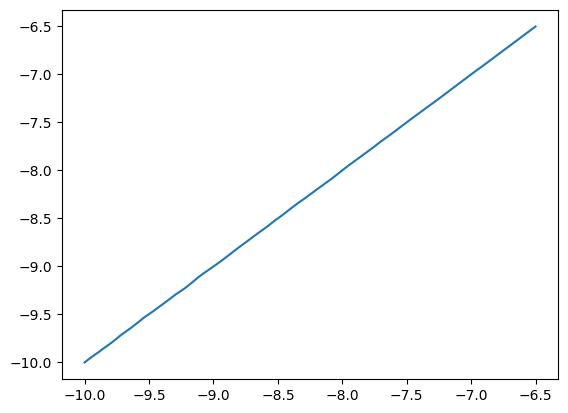

In [56]:
plt.plot(np.log10(narr),predictions)